# 项目：TMDb电影数据分析报告

## 目录

<ul>
<li><a href="#intro">简介</a></li>
<li><a href="#wrangling">数据整理</a></li>
<li><a href="#eda">探索性数据分析</a></li>
<li><a href="#conclusions">结论</a></li>
</ul>

<a id='intro'></a>

## 简介
TMDb电影数据集包含了 1960 年到 2015 年上映的大概一万部电影的信息，其中包括票房、电影名、演员、评分、电影风格等信息。对于电影的评分使用最多的就是TMDb评分。  
要探索的问题有：
1. 评分在哪个分数段的电影最多？
2. 票房和评分之间有什么关系？
3. 评分最高的一百部电影的主要风格是什么？
4. 随着时间的推移，电影收入和数量是怎么变化的？

In [179]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
# magic word
%matplotlib inline
%reload_ext autoreload
# 使作图在jupyter notebook中能够显示出来，而不是通过弹出另外一个窗口来显示
# 修改脚本后，不用手动重新导入，自动完成该操作

解决Matplotlib输出中文显示问题：

In [180]:
from pylab import mpl

mpl.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

<a id='wrangling'></a>
## 数据整理

In [181]:
# 加载数据并打印几行。进行这几项操作，来检查数据类型，以及是否有缺失数据或错误数据的情况。
movies_df = pd.read_csv('tmdb-movies.csv')
movies_df.info() # 检查数据

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

在将数据导入以后，肯定要对数据进行理解，即知道各个数据所代表的含义。 数据字段含义如下：

* imdb_id：IMDB 标识号
* popularity：在 Movie Database 上的相对页面查看次数
* budget：预算（美元）
* revenue：收入（美元）
* original_title：电影名称
* cast：演员列表，按 | 分隔，最多 5 名演员
* homepage：电影首页的 URL
* director：导演列表，按 | 分隔，最多 5 名导演
* tagline：电影的标语
* keywords：与电影相关的关键字，按 | 分隔，最多 5 个关键字
* overview：剧情摘要
* runtime：电影时长
* genres：风格列表，按 | 分隔，最多 5 种风格
* production_companies：制作公司列表，按 | 分隔，最多 5 家公司
* release_date：首次上映日期
* vote_count：评分次数
* vote_average：平均评分
* release_year：发行年份
* budget_adj：根据通货膨胀调整的预算（2010 年，美元）
* revenue_adj：根据通货膨胀调整的收入（2010 年，美元）

这些数据字段并不是每一个都是我们本次报告所需求的，在接下来的过程中，根据所要解决的问题，首先对这些数据进行一个清洗。

**删除缺失值太多或对分析没有用的列**  
**删除对分析结果无关的列（该报告主要分析与电影评分相关的内容以及电影数量和票房随时间的变化情况）**

In [182]:
drop_columns = ['imdb_id','id','overview','runtime','release_date','tagline','keywords',
                'production_companies','budget_adj','revenue_adj','cast','homepage','director']
movies_df.drop(drop_columns, axis=1, inplace=True)

#### 删除重复行和含有缺失值的行

In [183]:
# 删除重复行
print(movies_df.duplicated().sum())
movies_df.drop_duplicates(inplace=True)

1


In [184]:
# 删除含有缺失值的行
movies_df.dropna(inplace=True) # how='any'
print(movies_df.shape)

(10842, 8)


这里的缺失值处理不是很好。直接删除有缺失值的行，可能会引起大片输出的删除，丢失许多宝贵的信息。所以，建议要根据分析来进行缺失值的处理，比如说：如果C特征有大量缺失，但是只需要分析A特征与B特征的相互关系，那么就没必要对C特征进行缺失值的处理，只针对A特征跟B特征进行特征处理就足够了。同理其他特征也是一样。

#### 移动 vote_average 列到第一的位置

In [185]:
vote_average = movies_df.pop('vote_average')
movies_df.insert(0, 'vote_average', vote_average)

#### 对 vote_average 进行降序排序

In [186]:
movies_df = movies_df.sort_values(by="vote_average", ascending=False)

movies_df.index = np.arange(len(movies_df.index)) # 设置索引
movies_df[:].iloc[:1]

,vote_average,popularity,budget,revenue,original_title,genres,vote_count,release_year
0,9.2,0.006925,0,0,The Story of Film: An Odyssey,Documentary,14,2011


In [187]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10842 entries, 0 to 10841
Data columns (total 8 columns):
vote_average      10842 non-null float64
popularity        10842 non-null float64
budget            10842 non-null int64
revenue           10842 non-null int64
original_title    10842 non-null object
genres            10842 non-null object
vote_count        10842 non-null int64
release_year      10842 non-null int64
dtypes: float64(2), int64(4), object(2)
memory usage: 762.3+ KB


<a id='eda'></a>
## 探索性数据分析

计算统计值，创建可视化图表。采用系统化方法，一次只探索一个变量，然后探索变量之间的关系。

### 1. 评分在哪个分数段的电影最多？

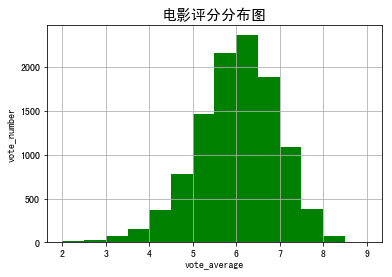

In [188]:
bins = [2,3,4,5,6,7,8,9]
bins = np.linspace(2, 9, 15, endpoint=True)
plt.title('电影评分分布图', fontsize='15')
plt.xlabel('vote_average')
plt.ylabel('vote_number')
plt.hist(movies_df['vote_average'], color='green', bins=bins);
plt.grid(True)

由直方图可以看出大多数的电影评分都在5.5~7.0分之间，呈左偏态。

### 2. 票房和评分之间有什么关系？

In [189]:
# 删除票房为0的列
revenue_df = movies_df[movies_df['revenue']!=0]

评分是连续的值，所以需要把评分分组，创建类别。

In [190]:
# 用于把数据“分割”成组的边缘数据
bin_edges = np.linspace(2, 8.5, 14, endpoint=True)
# 对每个评分水平类别进行标签命名
bin_names = np.linspace(2, 8, 13, endpoint=True).astype(str)
# pandas.cut()根据这些值将该列进行拆分，创建 vote_levels 列
vote_levels = pd.cut(revenue_df['vote_average'], bin_edges, labels=bin_names, right=False)
revenue_df.insert(len(revenue_df.columns), 'vote_levels', vote_levels)

注意：  
> revenue_df['vote_levels'] = pd.cut(revenue_df['vote_average'], bin_edges, labels=bin_names, right=False)  
会报警告：  
/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:  
A value is trying to be set on a copy of a slice from a DataFrame.  
Try using .loc[row_indexer,col_indexer] = value instead  
See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy  
  """Entry point for launching an IPython kernel.  
**修正方案**：  
先生成好正确的数组再插入dataframe中，如上一个cell所示。

In [191]:
revenue_df['vote_levels'].value_counts()

6.0    1204
6.5    1007
5.5     979
7.0     553
5.0     552
4.5     232
7.5     185
4.0      68
3.5      29
8.0      28
3.0      10
2.0       2
2.5       0
Name: vote_levels, dtype: int64

In [192]:
# 根据vote_levels 列进行分组并求平均值
revenue_mean = revenue_df.groupby('vote_levels')['revenue'].mean()
vote_levels = np.linspace(2, 8, 13, endpoint=True)

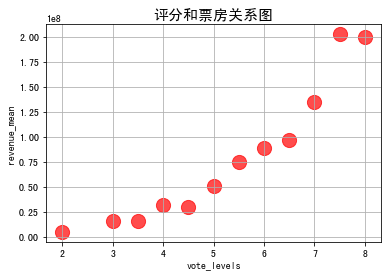

In [193]:
plt.xlabel('vote_levels')
plt.ylabel('revenue_mean')
plt.title(u'评分和票房关系图', fontsize='15')
plt.grid(True)
plt.scatter(vote_levels, revenue_mean, c='r', s=200, alpha=0.7);

从散点图可以看出，评分和票房是呈正相关的关系。

### 3. 评分最高的一百部电影的主要风格是什么？

In [194]:
vote_ranking = movies_df.iloc[:100]
vote_ranking.head(3)

,vote_average,popularity,budget,revenue,original_title,genres,vote_count,release_year
0,9.2,0.006925,0,0,The Story of Film: An Odyssey,Documentary,14,2011
1,8.9,0.114264,0,0,The Mask You Live In,Documentary,11,2015
2,8.8,0.222293,0,0,Life Cycles,Documentary,27,2010


In [195]:
# 得到包含所有电影风格的列表

'''这是之前的写法
genres_list = [] 
for i in vote_ranking['genres']:
    genres_list = genres_list + i.split('|')
'''

from functools import reduce
genres_list = vote_ranking['genres'].apply(lambda x: x.split('|'))
genres = pd.Series(reduce(lambda x,y: x+y, genres_list)) # 迭代列表求和

In [196]:
# 取前十五种风格
genres_counts = genres.value_counts().iloc[:15]

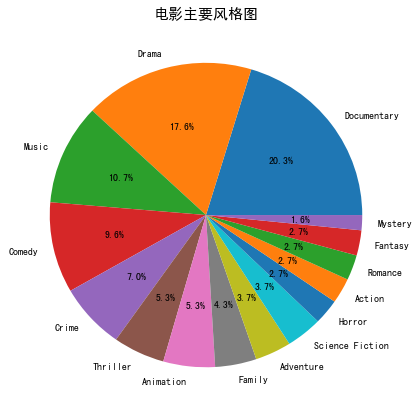

In [197]:
plt.figure(figsize=(7,7))
plt.title('电影主要风格图', fontsize='15')
labels = genres_counts.index
plt.pie(genres_counts.values, labels = labels, autopct='%1.1f%%');

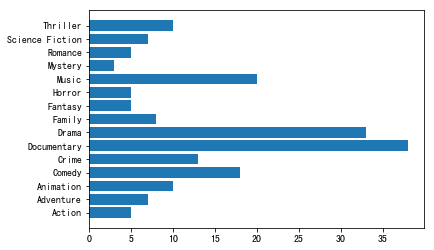

In [198]:
# 横向柱状图
plt.barh(genres_counts.index[::-1], genres_counts.values[::-1]); # [::-1]表示反向排序

高评分电影的主要风格有：Drama, Documentary, Music, Crime, Comedy。

**制作电影风格的词云图**

In [199]:
import jieba                      #分词库
from wordcloud import WordCloud   #词云库

In [200]:
# 将各电影的风格以‘/’分隔，形成字符串

'''这是之前的写法
genres_str = ''
for i in genres.astype(str):
    genres_str = genres_str + i + '/'
genres_str = genres_str[:-1]
'''

genres_str = "/".join(genres.values)

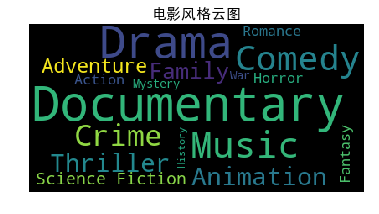

In [201]:
# 对分词后的文本生成词云
genres_wordcloud = WordCloud().generate(genres_str)
plt.title('电影风格云图', fontsize='15')
plt.imshow(genres_wordcloud)
plt.axis("off"); #去掉x,y轴的刻度

### 4、随着时间的推移，电影收入和数量是怎么变化的？

In [202]:
# 移除收入为0的列
revenue_df = movies_df[movies_df['revenue']!=0]

In [203]:
# 统计每个年份的电影数量，并按照年份排序
movie_num = revenue_df['release_year'].value_counts().sort_index()

In [204]:
# 统计每个年份的电影收入
movie_revenue = revenue_df.groupby('release_year').sum()['revenue']

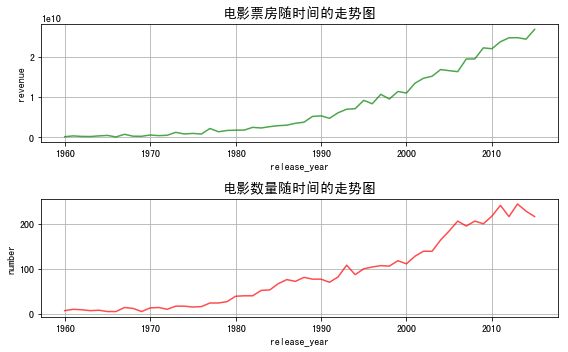

In [205]:
plt.figure(figsize=(8,5))

plt.subplot(211)
plt.grid(True)
plt.ylabel('revenue')
plt.xlabel('release_year')
plt.title('电影票房随时间的走势图', fontsize='14')
plt.plot(movie_revenue, color='green', alpha=.7)

plt.subplot(212)
plt.grid(True)
plt.ylabel('number')
plt.xlabel('release_year')
plt.title('电影数量随时间的走势图', fontsize='14')
plt.plot(movie_num, color='red', alpha=.7);

plt.tight_layout() # 调整子图之间的距离

随着时间的推移，电影事业得到了巨大的发展，电影数量和收入都大幅增加，而且是同步增加。

<a id='conclusions'></a>
## 结论

> 总结调查结果。请确保你了解在探索过程中的局限性。如果尚未进行任何统计检验，不要做出任何统计结论。切记不要根据相关关系贸然推导出因果关系！

In [206]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

255

经过对该电影数据集的分析，可以得到以下结论：
1. 随着时间的推移，电影获得了巨大发展，尤其是1990年之后，电影数量和票房增加迅速。
2. 电影评分和票房呈正相关关系，说明电影质量高，观众是愿意为其买单的。
3. 大多数电影的评分主要分布在5.5~7.0分之间，比较明显的正态分布。
4. 高评分的电影风格主要有Drama、Documentary、Music等。

#### 局限性：
1. 某些电影的评分次数太少（小于50），这使得电影评分很有可能不能真实反映出电影的质量水平；
2. 电影收入为零的无效数据太多（占一半多），降低了最后结果的可靠性；

参考：
1. [IMDB Movie :Python数据分析报告](https://zhuanlan.zhihu.com/p/34034272)  
2. [IMDB电影数据分析](https://www.kesci.com/apps/home/project/5ad5a5687238515d80b55cba/code)  
3. [TMDB电影数据分析](https://zhuanlan.zhihu.com/p/35164262)